In [2]:
#%reset
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np
import eli5
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from eli5.sklearn import PermutationImportance
## read data 
hfont = {'fontname':'Helvetica'}
CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")
print(CIP_data_no_drop.columns)

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'CLINIC', 'YEAR',
       'GENDERSP', 'Susceptible', 'MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing',
       'REGION', 'Midwest', 'Northeast', 'Southeast', 'Southwest', 'West',
       'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION'],
      dtype='object')


(2000.0, 2020.0)
(0.0, 0.5)


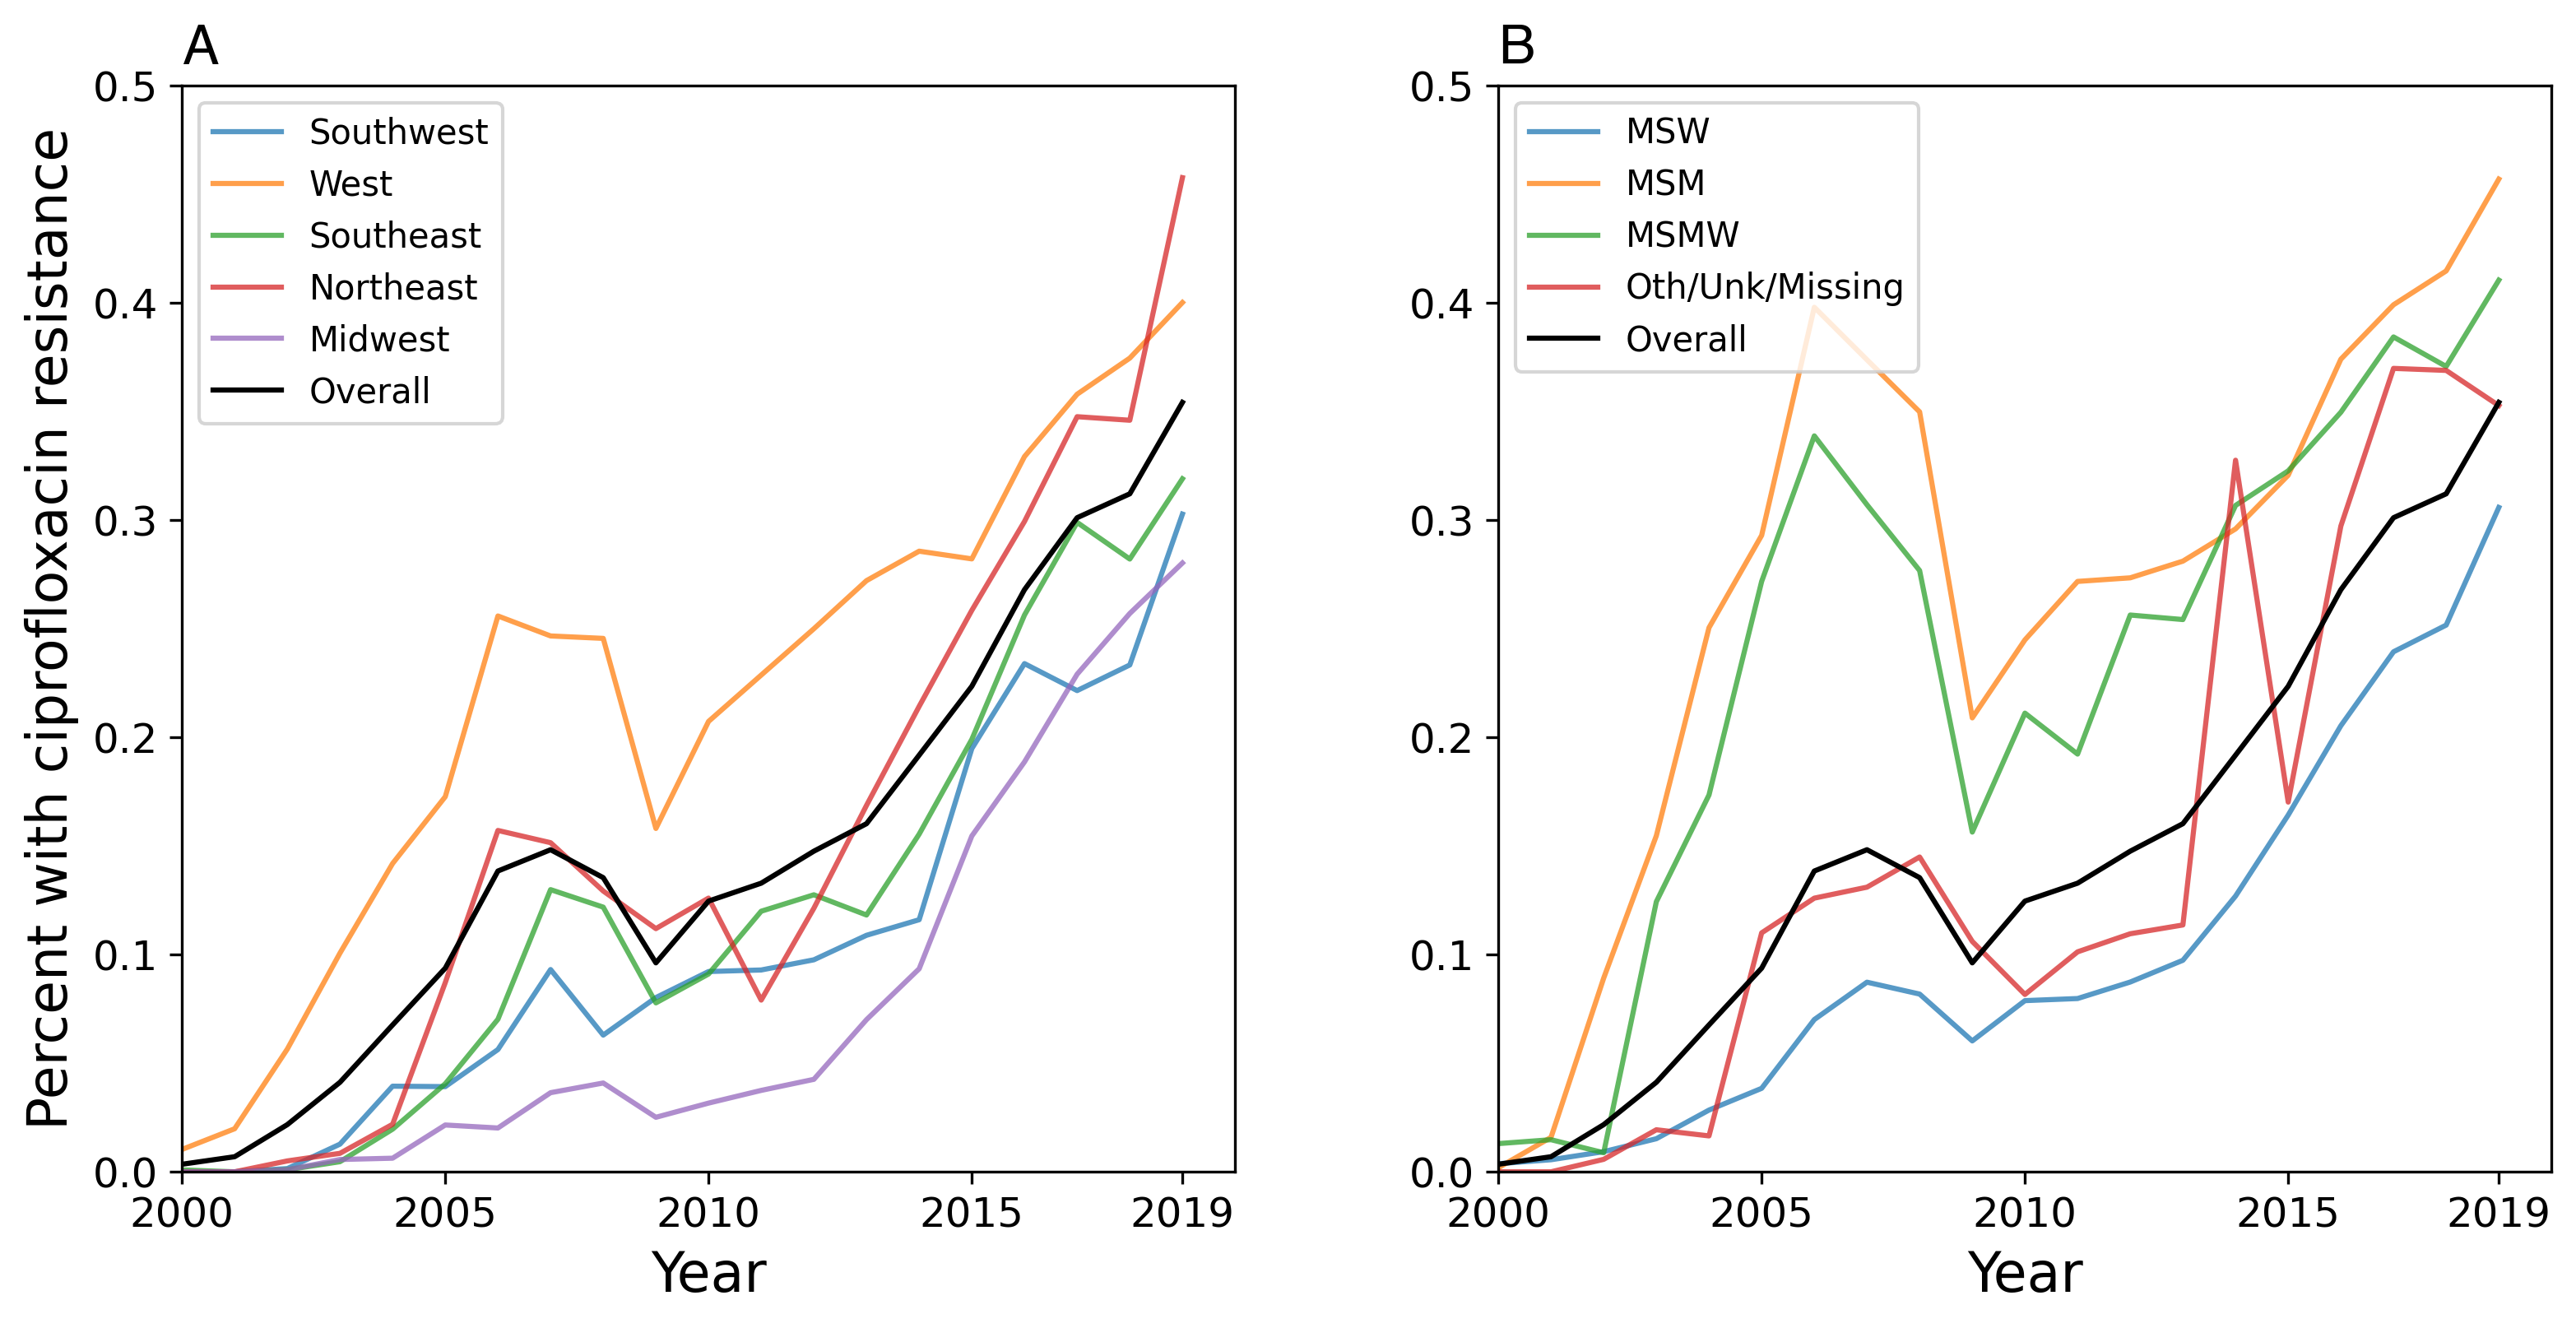

In [66]:
########### GRAPH SHOWING TRENDS IN RESISTANCE ###########
### Overall data 
xAxisYears = [2000, 2005, 2010, 2015, 2019]
years = CIP_data_no_drop["YEAR"].unique()
reistance_by_year_overall = []
reistance_by_year_all = pd.DataFrame() 
for year in years:
    CIP_data_year = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'] == year]
    reistance_by_year_overall.append(1 - CIP_data_year["Susceptible"].sum()/len(CIP_data_year))


fig, (ax1, ax2) = plt.subplots(1, 2)
plt.setp(ax1, xlim=(2000, 2020), ylim=(0,.50), xticks=[2000, 2005, 2010, 2015, 2019])
plt.setp(ax2, xlim=(2000, 2020), ylim=(0,.50), xticks=[2000, 2005, 2010, 2015, 2019])
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.25,
                    hspace=1.4)
## By region

regions = CIP_data_no_drop["REGION"].unique()

plt.subplot(1, 2, 1) 
#plt.subplots(figsize=(7.5, 3.75))

for region in regions:
    CIP_data_region = CIP_data_no_drop.loc[CIP_data_no_drop['REGION'] == region]
    reistance_by_year = []
    for year in years:
        CIP_data_region_year = CIP_data_region.loc[CIP_data_region['YEAR'] == year]

        reistance_by_year.append(1 - CIP_data_region_year["Susceptible"].sum()/len(CIP_data_region_year))
    ax1.plot(years, reistance_by_year, label=region, alpha=0.75)

ax1.plot(years, reistance_by_year_overall, color = "black", label = "Overall")

legend_labels = [regions, 'Overall']


### By gender of sp 
genders = CIP_data_no_drop["GENDERSP"].unique()

plt.subplot(1, 2, 1) 
#plt.subplots(figsize=(7.5, 3.75))

#reistance_by_year_all = pd.DataFrame()
for gender in genders:
    CIP_data_region = CIP_data_no_drop.loc[CIP_data_no_drop['GENDERSP'] == gender]
    reistance_by_year = []
    for year in years:
        CIP_data_region_year = CIP_data_region.loc[CIP_data_region['YEAR'] == year]

        reistance_by_year.append(1 - CIP_data_region_year["Susceptible"].sum()/len(CIP_data_region_year))
        
    ax2.plot(years, reistance_by_year, label=gender, alpha=0.75)

ax2.plot(years, reistance_by_year_overall, color = "black", label = "Overall")

legend_labels = [genders, 'Overall']
ax1.set_xlabel('Year', fontsize = 16.0)
ax1.set_ylabel('Percent with ciprofloxacin resistance', fontsize = 16.0)
ax2.set_xlabel('Year', fontsize = 16.0)
ax1.legend()
ax2.legend(loc="upper left")
#ax1.annotate("A", xy=(0, 0.51), xycoords=trans,annotation_clip=False)
ax1.text(ax1.get_xlim()[0] , ax1.get_ylim()[1] + 0.01, 'A', fontsize = 16, **hfont)
ax2.text(ax1.get_xlim()[0] , ax1.get_ylim()[1] + 0.01, 'B', fontsize = 16, **hfont)

#ax1.set_title('ax1 title')
#ax2.set_title('ax2 title')

#plt.tight_layout()
print(ax1.get_xlim())
print(ax1.get_ylim())

plt.savefig('Trends_in_ciprofloxacin_reisistance_region_gendersp.png')


In [88]:
### Permutation importance w/ hyperparameters and ENTIRE dataset 
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 5000 ,hidden_layer_sizes= 14, alpha =1.291549665014884, random_state=10, learning_rate = 'adaptive' )
#model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 16, alpha = 0.469873, random_state=10, learning_rate = 'adaptive' )

#train data: 2000 - 2010
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)
model_fit = model_nn.fit(X_train, y_train)

#test data: 2009 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_test = 1 - test_data['Susceptible']
X_test, y_test = oversample.fit_resample(X_test,y_test)

y_predict = model_nn.predict(X_test)

ROC_AUC_neural_network = metrics.roc_auc_score(y_test, y_predict)

print('ROC_AUC_nn:', ROC_AUC_neural_network) 

print(ROC_AUC_neural_network)
perm = PermutationImportance(model_fit, random_state=1).fit(X_test,y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

ROC_AUC_nn: 0.6133720679704389
0.6133720679704389


Weight,Feature
0.1089 ± 0.0022,PREV_REGION
0.0255 ± 0.0010,PREV_CLINIC
0.0150 ± 0.0030,West
0.0126 ± 0.0012,DELTA_REGION
0.0117 ± 0.0022,MSM
0.0043 ± 0.0011,Southeast
0.0040 ± 0.0012,Southwest
0.0007 ± 0.0004,MSMW
0.0006 ± 0.0002,Oth/Unk/Missing
0.0000 ± 0.0007,Northeast


In [89]:
###### Specificity and sensitivity of model on entire dataset - WITHOUT SECOND HYPERPARAMETER TUNING IS PRACTICE FOR GRAPHING
###### Dropping MSW and Midwest 

model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 14, alpha = 1.291549665014884, random_state=10, learning_rate = 'adaptive' )

#loop setup
threshold_seq = np.linspace(0,1,101)

#   train 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
X_train = train_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)

# test
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]

X_test = test_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']]
y_test = 1 - test_data['Susceptible']
X_test, y_test = oversample.fit_resample(X_test,y_test)

 #1. Create model using all data and get the apparent sensitivity and specificty 

model_fit_train = model_nn.fit(X_train, y_train)

  #2. Test model on test data to get test specificity and sensitivity 
  
y_predict = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)
#dataframes
sensitivity_test_threshold = []
specificity_test_threshold = [] #no bootstrapping, no 95% CI 

for threshold in threshold_seq:
  #print(threshold)
 
 
  y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

  tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

  sensitivity_test  = tp_test  / (tp_test   + fn_test )
  specificity_test   = tn_test / (tn_test + fp_test )
  
  # Save results
  sensitivity_test_threshold.append(sensitivity_test)
  specificity_test_threshold.append(specificity_test)

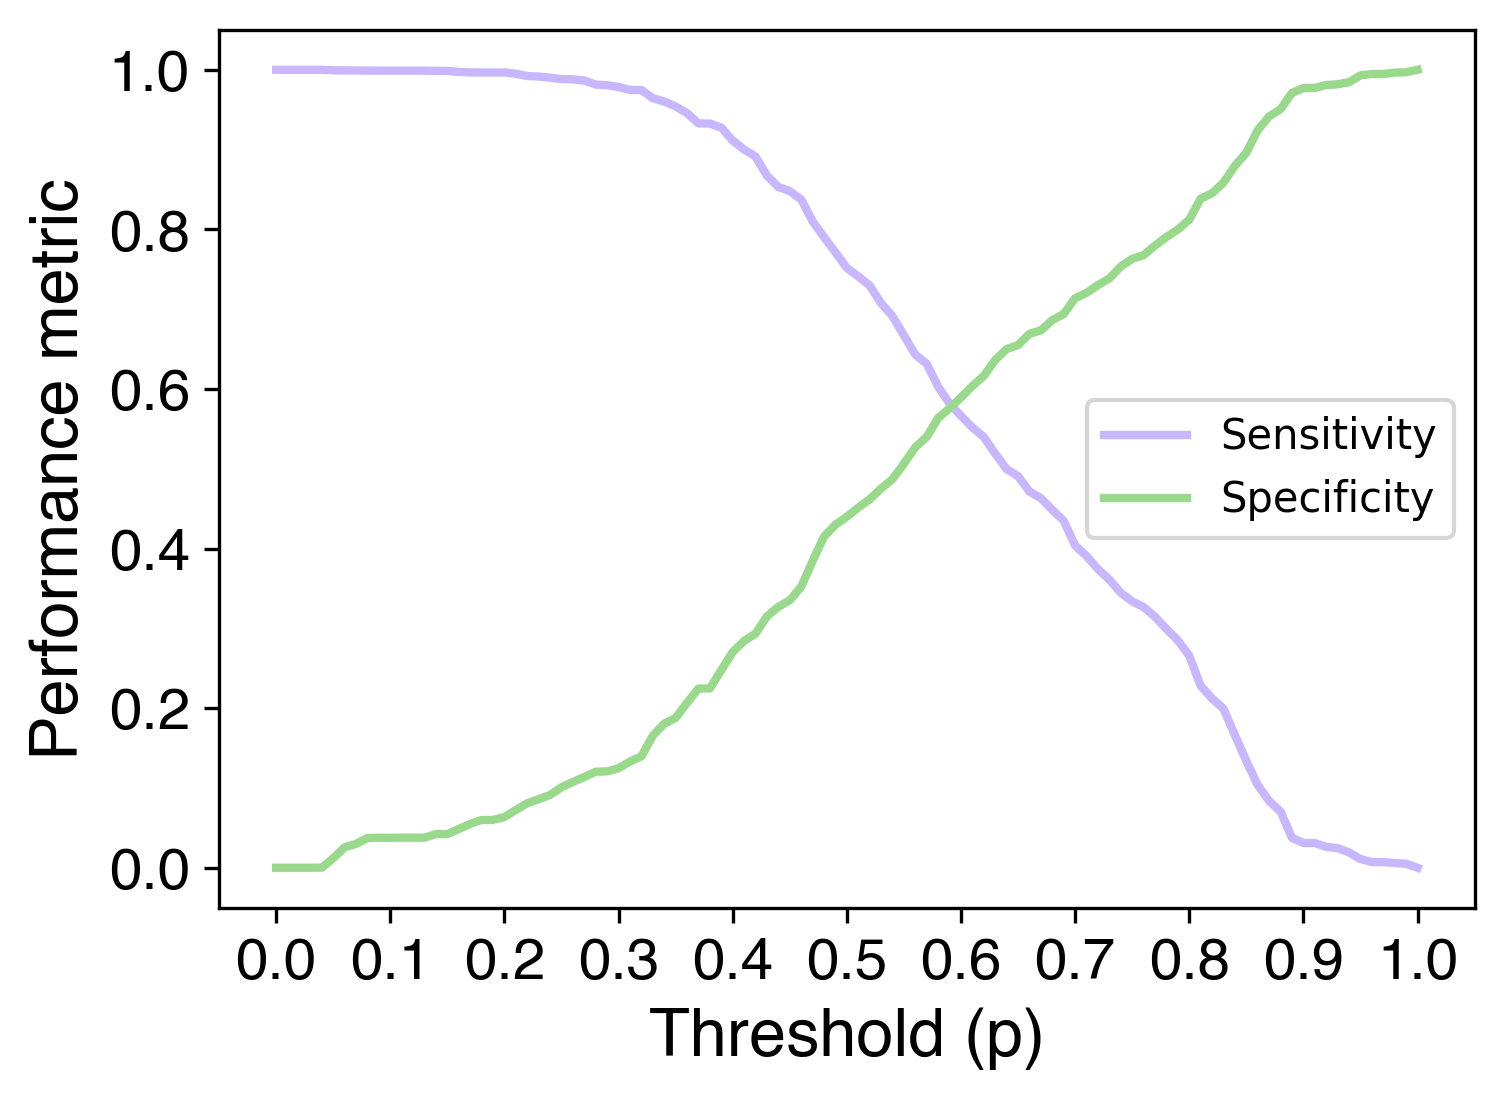

In [102]:
##### Graph of sensitivity and specificity 
hfont = {'fontname':'Helvetica'}

plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(5.4,3.8))
sensitivity_test_threshold = pd.DataFrame(sensitivity_test_threshold)
specificity_test_threshold = pd.DataFrame(specificity_test_threshold)
threshold_seq = np.linspace(0,1,101)

plt.plot(threshold_seq, sensitivity_test_threshold, color = "#c8b6ff", label = "Sensitivity", linewidth = 2)
plt.plot(threshold_seq, specificity_test_threshold, color = "#99d98c", label = "Specificity", linewidth = 2)
#plt.errorbar(threshold_seq, specificity_test_table, yerr = y_err_sensitivity, ecolor="lightblue")

plt.xlabel("Threshold (p)", fontsize=16, **hfont)
plt.ylabel("Performance metric", fontsize=16,**hfont)
plt.xticks(np.linspace(0,1,11), fontsize=14,**hfont)
plt.yticks(np.linspace(0,1,6), fontsize=14,**hfont)

plt.legend()

In [155]:
########### Now do proportion receiving effective and unnecessary treatment for years surrounding 2007 decision 

#### Overall model effective and unnecessary treatment -- all test and train years 

model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 14, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )
#train data: 2000 - 2010 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)


#test data: 2011 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
X_test = test_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']]
y_test = 1 -  test_data['Susceptible']
cipro_R_prev_all= y_test.sum()/len(y_test) #get prevalence in 2011 before radndom oversampling
X_test, y_test = oversample.fit_resample(X_test,y_test)

print(cipro_R_prev_all)

model_fit_train = model_nn.fit(X_train, y_train)
y_predict_test = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)

ROC_AUC_neural_network = metrics.roc_auc_score(y_test, y_predict_test)

0.23081886682486158


In [158]:
### Loop over thresholds to see how classification threshold affects proportion receiving effective and unnecessary treatment ALL TEST DATA
threshold_seq = np.linspace(0,1,101)

get_effective_threshold = []
incorrectly_get_X_threshold = [] #no bootstrapping, no 95% CI 

for threshold in threshold_seq:

  y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

  tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

  sensitivity_test  = tp_test  / (tp_test   + fn_test )
  specificity_test   = tn_test / (tn_test + fp_test )
  
  get_effective_threshold.append(sensitivity_test * cipro_R_prev_all + (1 -  cipro_R_prev_all)) #q_p
  incorrectly_get_X_threshold.append((1 - cipro_R_prev_all) * (1 - specificity_test)) #c_p

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_26146/2276991127.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot([1, 1-cipro_R_prev_all], [1-cipro_R_prev_all, 0], 'bo', color = "#e5e5e5", linestyle="--")


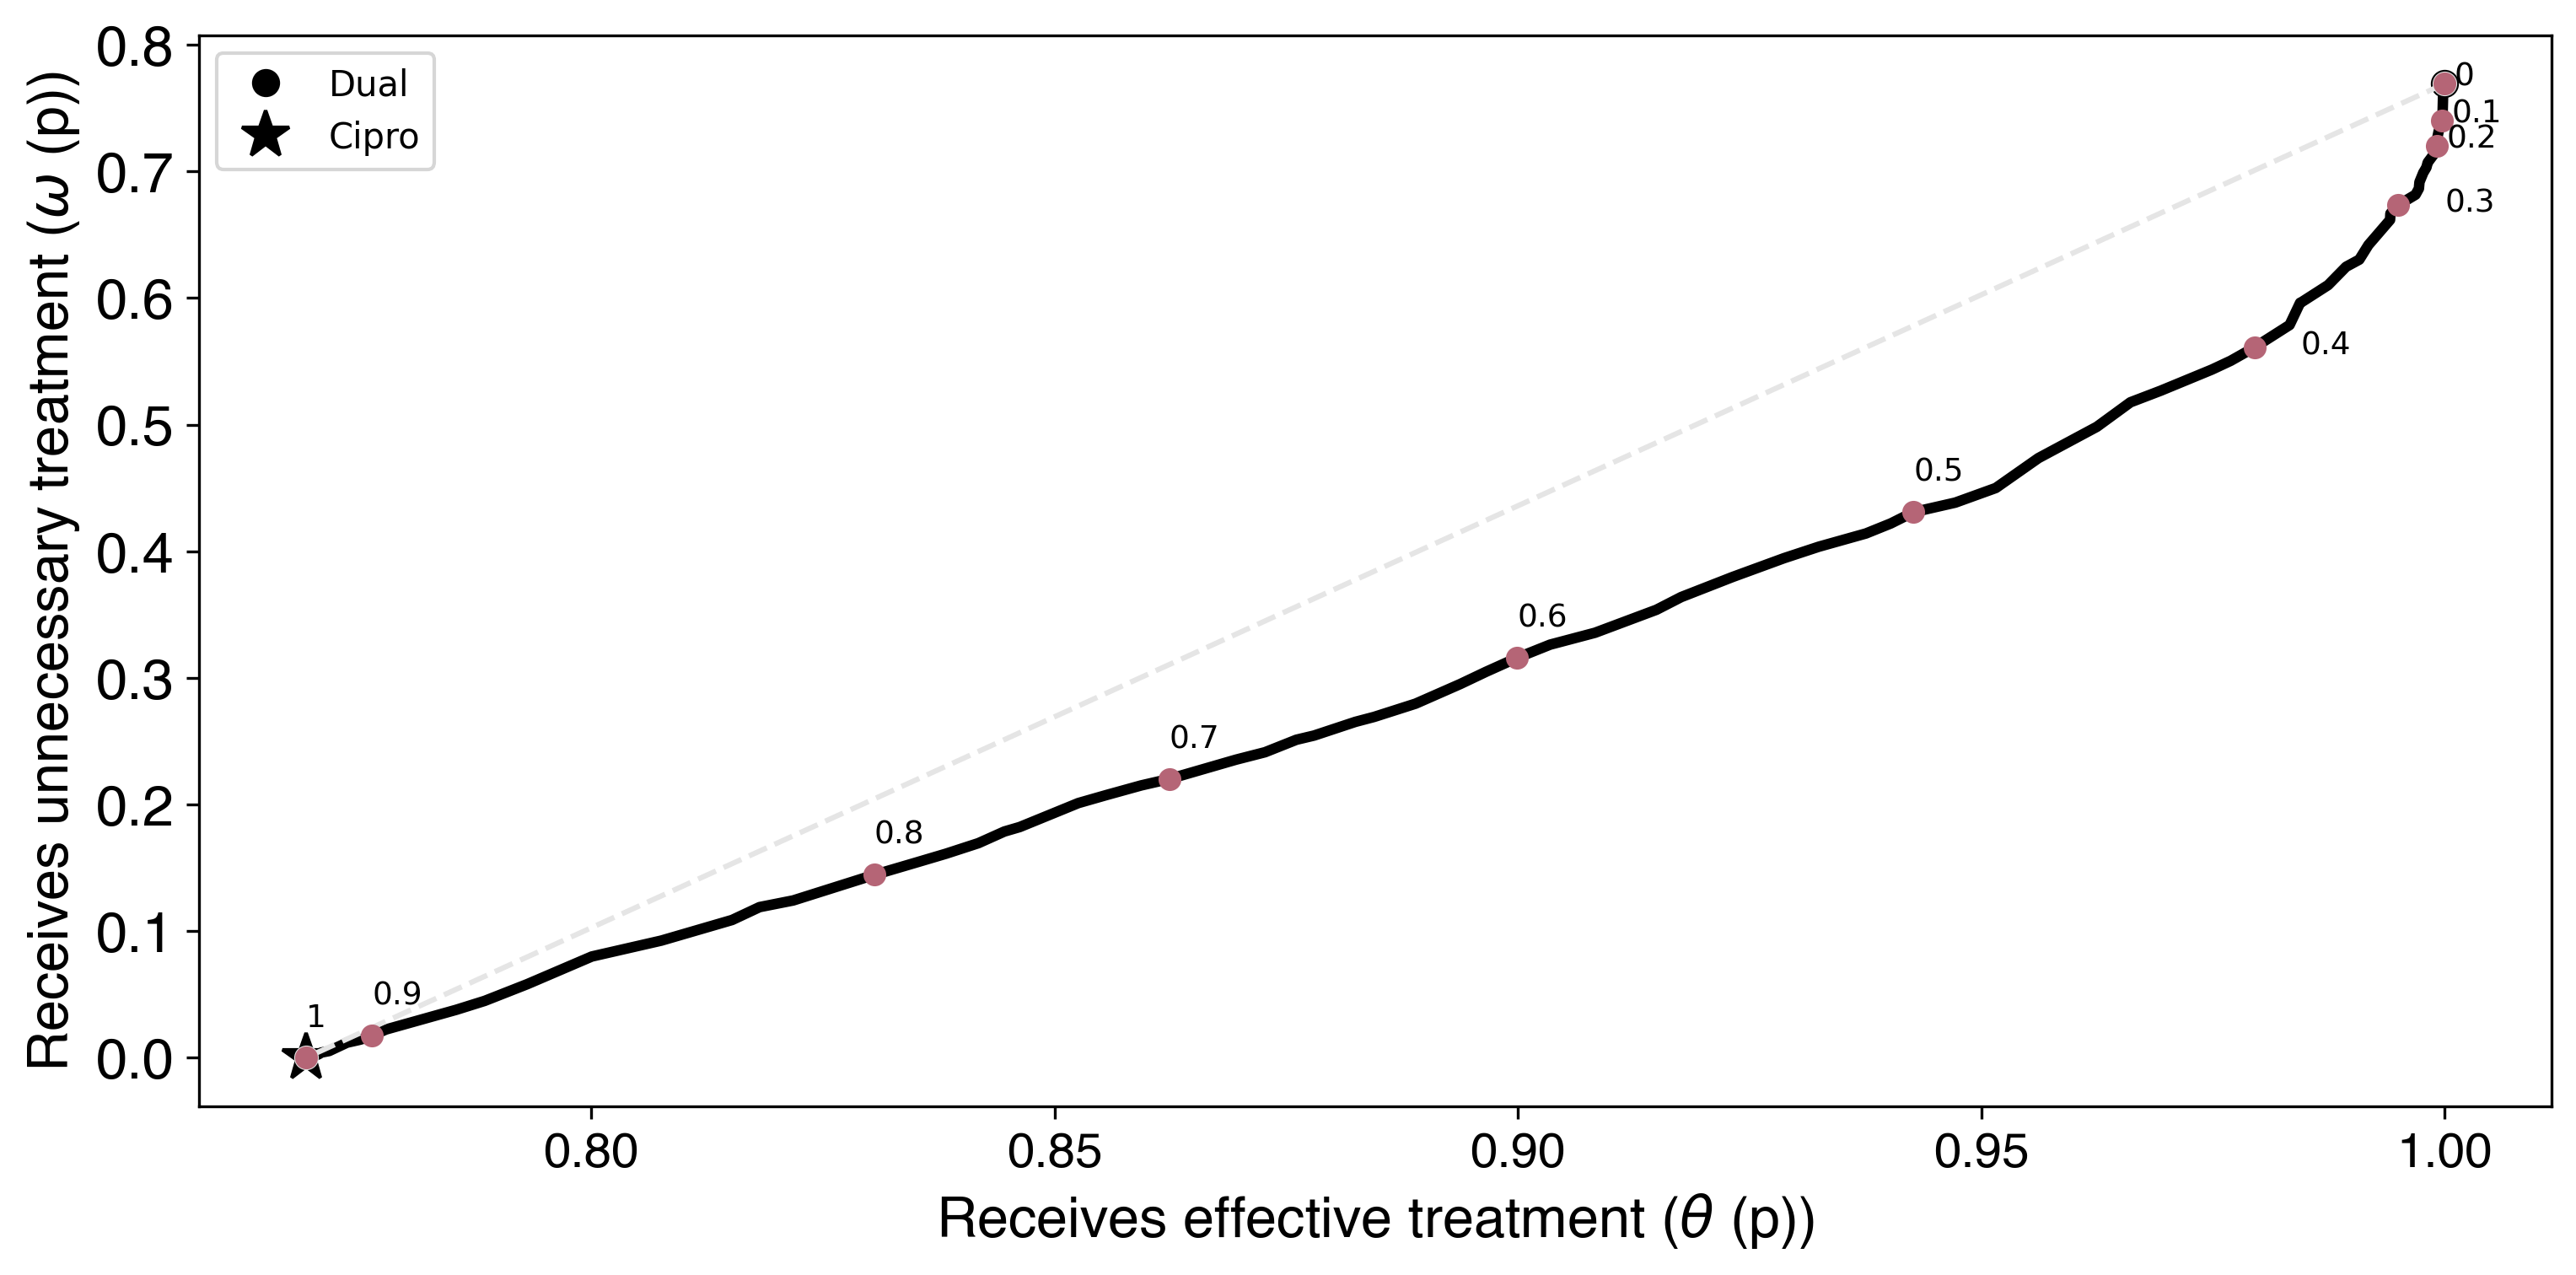

In [165]:
### Plotting overall with all training data 

plt.plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)

plt.xlabel(r"Receives effective treatment ($\theta$(p))", fontsize=16, **hfont)
plt.ylabel("Receives unnecessary treatment ($\omega$(p))", fontsize=16, **hfont)
plt.xticks(np.linspace(0,1,21), fontsize=14, **hfont)
plt.yticks(np.linspace(0,1,11), fontsize=16, **hfont)

plt.rcParams['figure.dpi'] = 300

plt.plot(1, 1 - cipro_R_prev_all, marker='.', ls='none', ms=14, color = "black", label = "Dual")
plt.plot((1-cipro_R_prev_all), 0, marker='*', ls='none', ms=14, color = "black", label = "Cipro")
plt.plot([1, 1-cipro_R_prev_all], [1-cipro_R_prev_all, 0], color = "#e5e5e5", linestyle="--")
plt.legend()
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
x = 0
for index in indices:
    plt.plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
    if get_effective_threshold[index] > 0.996:
        plt.text(get_effective_threshold[index] + 0.001, incorrectly_get_X_threshold[index] - 0.001, text_for_graph[x], size = 9)
    elif (get_effective_threshold[index] > 0.95) & (get_effective_threshold[index] < 0.996):
        plt.text(get_effective_threshold[index] + 0.005, incorrectly_get_X_threshold[index] - 0.005, text_for_graph[x], size = 9)
    else:
        plt.text(get_effective_threshold[index], incorrectly_get_X_threshold[index] + 0.025, text_for_graph[x], size = 9)
    x = x+1

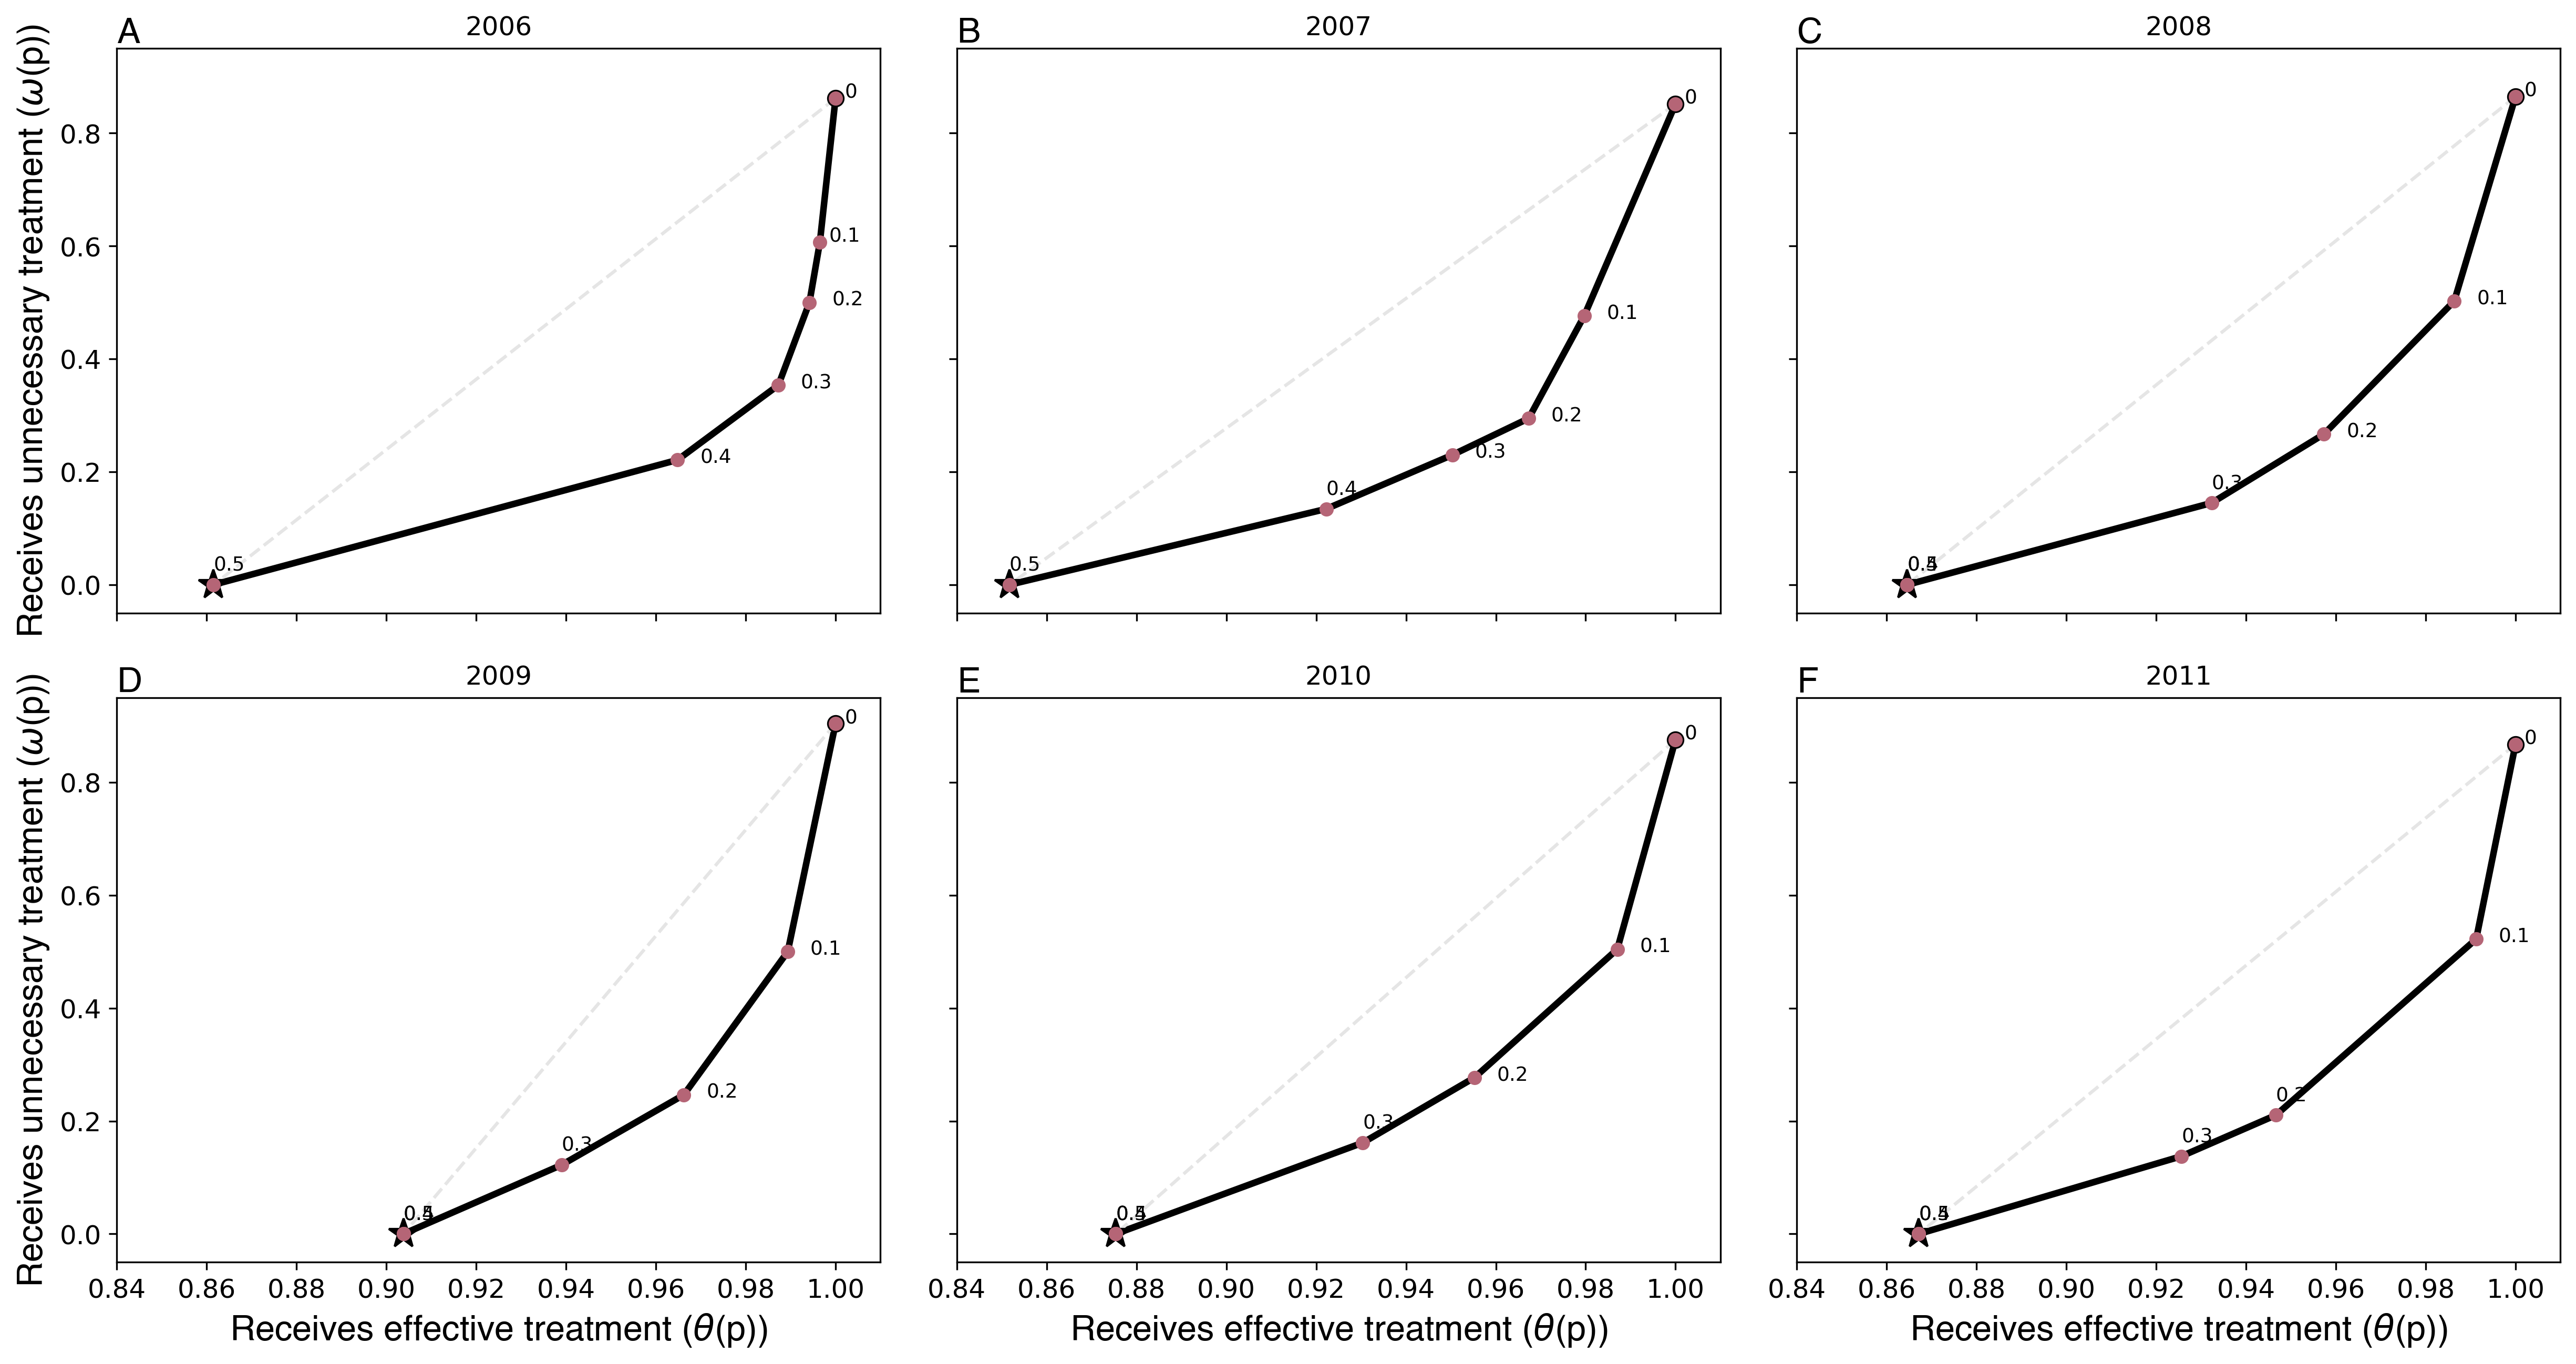

In [174]:
### now do a loop over different years to get the proportion receiving effective and unnecessary treatment 
threshold_seq = np.linspace(0,1,101)
labels = ["A", "B", "C", "D", "E", "F" ]
years = [2006, 2007, 2008, 2009, 2010, 2011]
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
 #   if (i == 0) | (i == 3):
 #       axs[i].ylabel("Receives unnecessary treatment ($\omega$(p))", fontsize=16, **hfont)
 #   if(i == 3) | (i == 4) | (i == 5):
 #       axs[i].xlabel(r"Receives effective treatment ($\theta$(p))", fontsize=16, **hfont)

fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
#fig.set_ylabel("Receives unnecessary treatment ($\omega$(p))", fontsize=16, **hfont)
#fig.set_xlabel(r"Receives effective treatment ($\theta$(p))", fontsize=16, **hfont)
fig.subplots_adjust(hspace = .15, wspace=.1)
axs = axs.ravel()
i = 0
for year in years: 
    model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )
    #train
    years_train = np.array(range(year - 5, year))
    train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    X_train = train_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']]
    y_train = 1 - train_data['Susceptible']
    X_train, y_train = oversample.fit_resample(X_train,y_train)
    #test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    X_test = test_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']]
    y_test = 1 - test_data['Susceptible']
    cipro_R_prev = y_test.sum()/len(y_test) #get prevalence in 2011 before radndom oversampling
    X_test, y_test = oversample.fit_resample(X_test,y_test)
    model_fit_train = model_nn.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)

    get_effective_threshold_prev_5 = []
    incorrectly_get_X_threshold_prev_5 = [] #no bootstrapping, no 95% CI 

    for threshold in threshold_seq:

        y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

        tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

        sensitivity_test  = tp_test  / (tp_test   + fn_test )
        specificity_test   = tn_test / (tn_test + fp_test )
    
        get_effective_threshold_prev_5.append(sensitivity_test * cipro_R_prev + (1 -  cipro_R_prev)) #q_p
        incorrectly_get_X_threshold_prev_5.append((1 - cipro_R_prev) * (1 - specificity_test)) #c_p
    x = 0
    axs[i].plot(get_effective_threshold_prev_5, incorrectly_get_X_threshold_prev_5,color = "black", linewidth = 3)
    axs[i].plot([1, 1-cipro_R_prev], [1-cipro_R_prev, 0], color = "#e5e5e5", linestyle="--")

    axs[i].set_ylim([0-0.05,0.95])
    axs[i].set_xlim([0.84, 1.01])
    if (i == 0) | (i == 3):
       axs[i].set_ylabel("Receives unnecessary treatment ($\omega$(p))", fontsize=16, **hfont)
    if(i == 3) | (i == 4) | (i == 5):
        axs[i].set_xlabel(r"Receives effective treatment ($\theta$(p))", fontsize=16, **hfont)

    axs[i].plot(1, 1 - cipro_R_prev, marker='.', ls='none', ms=14, color = "black", label = "Dual")
    axs[i].plot((1-cipro_R_prev), 0, marker='*', ls='none', ms=14, color = "black", label = "Cipro")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.01, labels[i], fontsize = 16, **hfont)
    axs[i].title.set_text(year, fontsize=16, **hfont)
    for index in indices:
        axs[i].plot(get_effective_threshold_prev_5[index], incorrectly_get_X_threshold_prev_5[index], marker='.', ls='none', ms=11, color = "#b56576")
        if get_effective_threshold_prev_5[index] > 0.996:
            axs[i].text(get_effective_threshold_prev_5[index] + 0.002, incorrectly_get_X_threshold_prev_5[index] + 0.001, text_for_graph[x], size = 9)
        elif (get_effective_threshold_prev_5[index] > 0.95) & (get_effective_threshold_prev_5[index] < 0.996):
            axs[i].text(get_effective_threshold_prev_5[index] + 0.005, incorrectly_get_X_threshold_prev_5[index] - 0.005, text_for_graph[x], size = 9)
        else:
            axs[i].text(get_effective_threshold_prev_5[index], incorrectly_get_X_threshold_prev_5[index] + 0.025, text_for_graph[x], size = 9)
        x = x+1
    i += 1   


In [240]:
###### Waterfall plot for permutation importance ############
### Permutation importance w/ hyperparameters and ENTIRE dataset 
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 5000 ,hidden_layer_sizes= 14, alpha =1.291549665014884, random_state=10, learning_rate = 'adaptive' )
#model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 16, alpha = 0.469873, random_state=10, learning_rate = 'adaptive' )

#train data: 2000 - 2010
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)
model_fit = model_nn.fit(X_train, y_train)

#test data: 2009 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_test = 1 - test_data['Susceptible']
X_test, y_test = oversample.fit_resample(X_test,y_test)

y_predict = model_nn.predict(X_test)


PI = permutation_importance(model_fit, X_test, y_test, n_repeats = 100, random_state = 42)
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','Prev. Region', 'Prev. Clinic','Change']

for i in PI.importances_mean.argsort()[::-1]:
    if PI.importances_mean[i] - 2 * PI.importances_std[i] > -1:
            print(f"{feature_names[i]:<8}"
            f"{PI.importances_mean[i]:.3f}"
            f" +/- {PI.importances_std[i]:.3f}")

Prev. Region0.109 +/- 0.001
Prev. Clinic0.024 +/- 0.001
West    0.014 +/- 0.001
Change  0.013 +/- 0.001
MSM     0.012 +/- 0.001
Southeast0.004 +/- 0.001
Southwest0.004 +/- 0.001
MSMW    0.001 +/- 0.000
Oth/Unk/Missing0.000 +/- 0.000
Northeast0.000 +/- 0.001
MSW     -0.008 +/- 0.001
Midwest -0.014 +/- 0.001


In [218]:
feature_names = np.array(feature_names)
feature_names_by_importance = feature_names[PI.importances_mean.argsort()[::-1]]
mean_importance_by_importance = PI.importances_mean[PI.importances_mean.argsort()[::-1]]
std_importance_by_importance = PI.importances_std[PI.importances_mean.argsort()[::-1]]

([<matplotlib.axis.YTick at 0x295ade5f0>,
 [Text(0, 0, 'PREV_REGION'),
  Text(0, 1, 'PREV_CLINIC'),
  Text(0, 2, 'West'),
  Text(0, 3, 'DELTA_REGION'),
  Text(0, 4, 'MSM'),
  Text(0, 5, 'Southeast'),
  Text(0, 6, 'Southwest'),
  Text(0, 7, 'MSMW'),
  Text(0, 8, 'Oth/Unk/Missing'),
  Text(0, 9, 'Northeast'),
  Text(0, 10, 'MSW'),
  Text(0, 11, 'Midwest')])

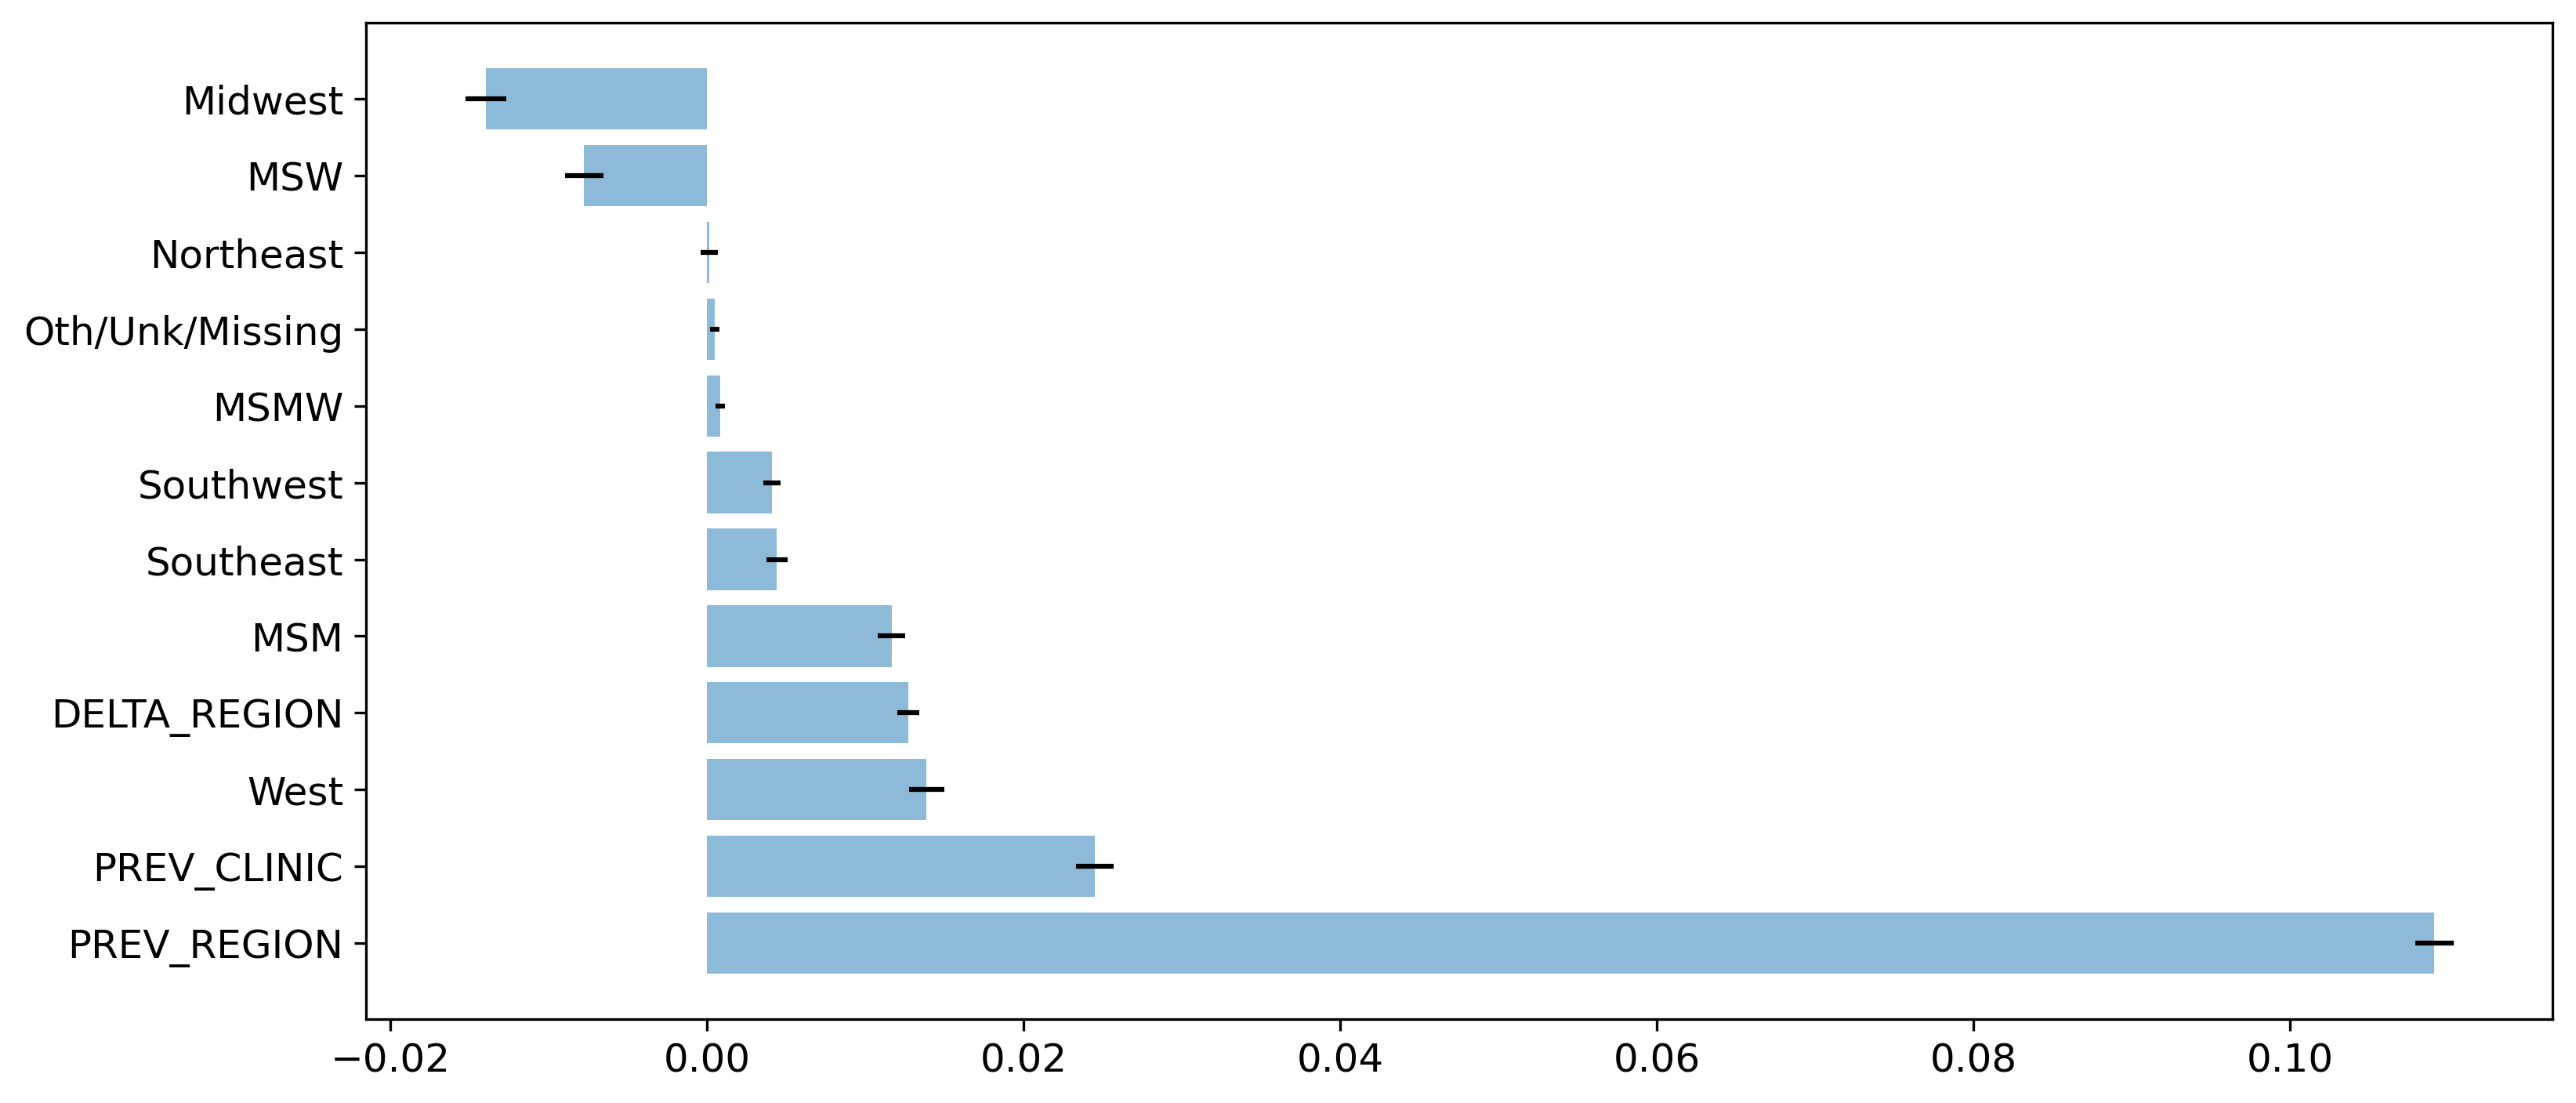

In [227]:
plt.barh(y = range(mean_importance_by_importance.size), width =mean_importance_by_importance,
 xerr= std_importance_by_importance, alpha = 0.5)#c8b6ff") # xmin = min(feature_names_by_importance), xmax = max(feature_names_by_importance))
plt.yticks(range(feature_names_by_importance.size), feature_names_by_importance)


In [229]:
#### Print cipro resistance by year for "writing" part of the paper 

years = CIP_data_no_drop["YEAR"].unique()
reistance_by_year_overall = []
reistance_by_year_all = pd.DataFrame() 
for year in years:
    CIP_data_year = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'] == year]
    #reistance_by_year_overall.append(1 - CIP_data_year["Susceptible"].sum()/len(CIP_data_year))
    print(year, " : ", 1 - CIP_data_year["Susceptible"].sum()/len(CIP_data_year))

2000  :  0.003479216260758089
2001  :  0.006946983546617935
2002  :  0.02171877925482124
2003  :  0.0412071078431373
2004  :  0.06761678543151228
2005  :  0.09375504276262703
2006  :  0.1384691195795007
2007  :  0.14827758362456311
2008  :  0.13541848680761837
2009  :  0.09619487908961588
2010  :  0.12462647213921607
2011  :  0.1328696925329429
2012  :  0.14760080277321652
2013  :  0.16026289180990905
2014  :  0.19181585677749358
2015  :  0.22352024922118385
2016  :  0.2679862961553102
2017  :  0.30112625963248374
2018  :  0.3121241513094083
2019  :  0.3542199488491049


0.17065111758989315
0.3095982537903369
0.19202477739063106
0.2515190278221938
0.15925646822406425


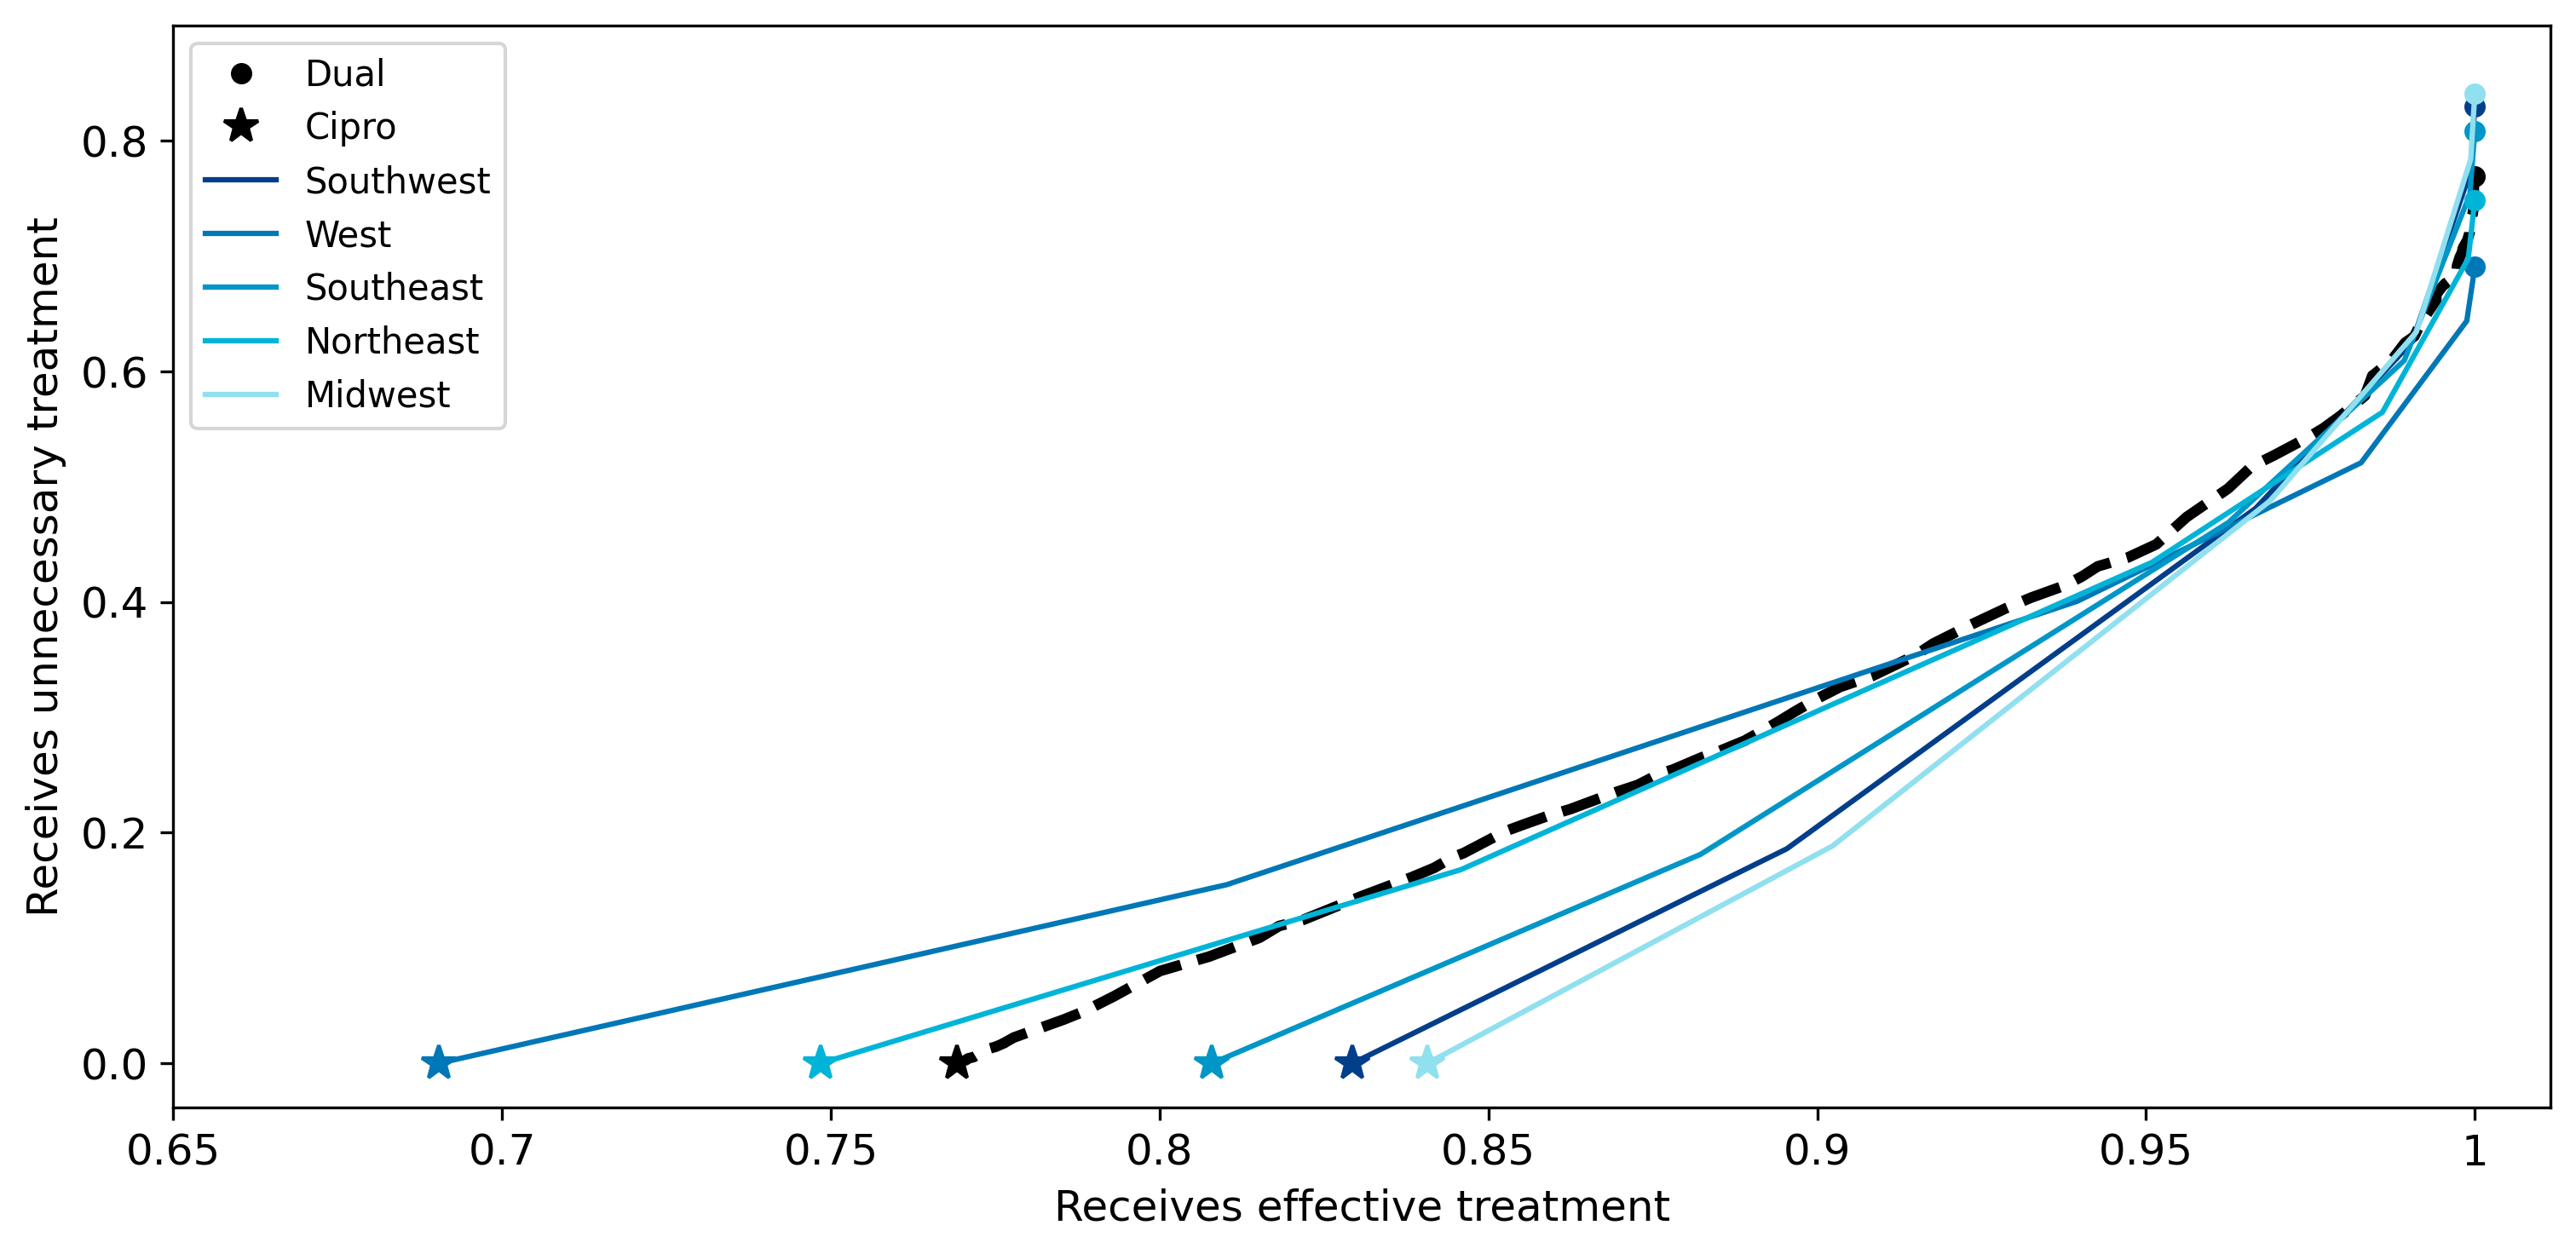

In [238]:
##### unnecessary and efficient by region 

model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )
#train data: 2000 - 2010 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([ 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)


#test data: 2011 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
X_test = test_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']]
y_test = 1 - test_data['Susceptible']
cipro_R_prev_all = y_test.sum()/len(y_test) #get prevalence in 2011 before radndom oversampling
X_test, y_test = oversample.fit_resample(X_test,y_test)


model_fit_train = model_nn.fit(X_train, y_train)
y_predict_test = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)

regions = test_data["REGION"].unique()

reistance_by_region  = []

for region in regions:
    CIP_data_region = test_data.loc[test_data['REGION'] == region]
    reistance_by_region.append(1 - CIP_data_region["Susceptible"].sum()/len(CIP_data_region))

### make main plot, then vary it by year 

plt.plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3, linestyle = "dashed" )

plt.xlabel("Receives effective treatment", fontsize=12)
plt.ylabel("Receives unnecessary treatment", fontsize=12)
plt.xticks((0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1), ['0.65', '0.7','0.75', '0.8','0.85', '0.9', '0.95', '1'], fontsize=12)
plt.rcParams['figure.dpi'] = 300
plt.xlim(left = 0.65)
plt.ylim(top = 0.9)
plt.plot(1, 1 - cipro_R_prev_all, marker='.', ls='none', ms=10, color = "black", label = "Dual")
plt.plot((1-cipro_R_prev_all), 0, marker='*', ls='none', ms=10, color = "black", label = "Cipro")
#plt.plot([0], get_effective_threshold[0], marker='*', ls='none', ms=10, color = "black", label = "Dual")
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
x = 0

#for index in indices:
#    plt.text(get_effective_threshold[index], incorrectly_get_X_threshold[index] + 0.025, text_for_graph[x])
#    x = x+1

x = 0
colours = ['#023e8a', '#0077b6', '#0096c7', '#00b4d8', '#90e0ef']

for cipro_R in reistance_by_region:
    print(cipro_R)
    get_effective_threshold_region = []
    incorrectly_get_X_threshold_region  = []
    for threshold in threshold_seq:

        y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

        tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

        sensitivity_test  = tp_test  / (tp_test   + fn_test )
        specificity_test   = tn_test / (tn_test + fp_test )
  
        get_effective_threshold_region .append(sensitivity_test * cipro_R + (1 -  cipro_R)) #q_p
        incorrectly_get_X_threshold_region .append((1 - cipro_R) * (1 - specificity_test)) #c_p
    plt.plot(get_effective_threshold_region , incorrectly_get_X_threshold_region , color = colours[x], label = regions[x])
    plt.plot(1, 1 - cipro_R, marker='.', ls='none', ms=10, color = colours[x])
    plt.plot((1-cipro_R), 0, marker='*', ls='none', ms=10, color = colours[x])
    x += 1

plt.legend()

In [251]:
### Hyperparameter tuning with entire dataset 

## now do hyperparameter tuning again post PI
space = dict()
#space['activation'] = ['tanh', 'relu']
space['alpha'] = [ 0.46415888, 1.29154967]
#space['learning_rate'] = ['constant','adaptive']
space['hidden_layer_sizes'] = [(14)]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 5000 ,hidden_layer_sizes= 12, alpha =  1.291549665014884, random_state=10, learning_rate = 'adaptive' )
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y = 1 - train_data['Susceptible']

#X = CIP_data_no_drop[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
#y = 1 - CIP_data_no_drop['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X, y = oversample.fit_resample(X,y)
model_fit = model_nn.fit(X, y)

search = RandomizedSearchCV(model_nn, space, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

#Best Score: 0.8081387251717022
#Best Hyperparameters: {'learning_rate': 'adaptive', 'hidden_layer_sizes': 14, 'alpha':1.291549665014884}

/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Score: 0.8597358406433855
Best Hyperparameters: {'hidden_layer_sizes': 14, 'alpha': 0.46415888}


In [241]:
print(np.logspace(-1, 1, 10)[1:6])

[0.16681005 0.27825594 0.46415888 0.77426368 1.29154967]


In [ ]:
######### NB LOGISTIC REGRESSION 
########### FIX LOOCV 
### now do a loop over different years to get the proportion receiving effective and unnecessary treatment 
### has LOOCV 
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')
threshold_seq = np.linspace(0,1,11)

test_years = [2005, 2006]
labels = ["A", "B", "C", "D", "E", "F" ]
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

## NEEDED FOR HYPERPARAMETER TUNING   
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2']
space['C'] = np.arange(0, 1, .01) #[0.001, 0.01, 0.1, 1, 10, 100, 1000] #np.arange(0, 1000, 1) #loguniform(1e-5, 100)


fig.subplots_adjust(hspace = .15, wspace=.1)
axs = axs.ravel()
i = 0
for year in test_years: 
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]

    # first do for all clinics 

    train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southwest',  'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
    y_train = 1 - train_data['Susceptible']
    #test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southwest',  'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
    y_test = 1 - test_data['Susceptible']

## Try and tune hyperparameters for just 2010

    search = RandomizedSearchCV(model_lr, space, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
    result = search.fit(X_train, y_train)

#{'solver': 'liblinear', 'penalty': 'l1', 'C': 0.67}
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = result.best_params_['solver'], C = result.best_params_['C'], penalty = result.best_params_['penalty'])

    # first do for all clinics - already subsetted test/train data

    cipro_R_prev = y_test.sum()/len(y_test) #get prevalence in 2011 before radndom oversampling
    model_fit_train = model_lr.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)

    get_effective_threshold_prev_5 = []
    incorrectly_get_X_threshold_prev_5 = [] #no bootstrapping, no 95% CI 

    for threshold in threshold_seq:

        y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

        tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

        sensitivity_test  = tp_test  / (tp_test   + fn_test )
        specificity_test   = tn_test / (tn_test + fp_test )
    
        get_effective_threshold_prev_5.append(sensitivity_test * cipro_R_prev + (1 -  cipro_R_prev)) #q_p
        incorrectly_get_X_threshold_prev_5.append((1 - cipro_R_prev) * (1 - specificity_test)) #c_p
    x = 0
    axs[i].plot(get_effective_threshold_prev_5, incorrectly_get_X_threshold_prev_5,color = "black", linewidth = 3)
    axs[i].plot(1, 1 - cipro_R_prev, marker='.', ls='none', ms=18, color = "#b56576", label = "Dual")
    axs[i].plot((1-cipro_R_prev), 0, marker='*', ls='none', ms=14, color = "#b56576", label = "Cipro")
    axs[i].set_ylim([0-0.05,1.01])
    axs[i].set_xlim([0.6, 1.01])
    clinics = CIP_data_testing_years["CLINIC"].unique()
    for clinic in clinics: 
        print(clinic)
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]
          #train data - does not have clinic
        X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southwest',  'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
        y_train = 1 - train_data['Susceptible']

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southwest',  'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)
        if cipro_R > 0: 
          try:
          # test 
              model_fit_train = model_lr.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              get_effective_threshold_region = []
              incorrectly_get_X_threshold_region  = []
              for threshold in threshold_seq:

                y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

                tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

                sensitivity_test  = tp_test  / (tp_test   + fn_test )
                specificity_test   = tn_test / (tn_test + fp_test )
                get_effective_threshold_region.append(sensitivity_test * cipro_R + (1 -  cipro_R)) #q_p
                incorrectly_get_X_threshold_region.append((1 - cipro_R) * (1 - specificity_test)) #c_p
              axs[i].plot(get_effective_threshold_region, incorrectly_get_X_threshold_region,color = "#e5e5e5", linewidth = 3)
              #axs[i].plot([1, 1-cipro_R], [1-cipro_R, 0], color = "#e5e5e5", linestyle="--")

              if (i == 0) | (i == 3):
                axs[i].set_ylabel("Receives unnecessary treatment ($\omega$(p))", fontsize=16, **hfont)
              if(i == 3) | (i == 4) | (i == 5):
                axs[i].set_xlabel(r"Receives effective treatment ($\theta$(p))", fontsize=16, **hfont)

              axs[i].plot(1, 1 - cipro_R, marker='.', ls='none', ms=18, color = "#e5e5e5")
              axs[i].plot((1-cipro_R), 0, marker='*', ls='none', ms=14, color = "#e5e5e5")
              axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.01, labels[i], fontsize = 16, **hfont)
              axs[i].title.set_text(year)
              if i == 0:
                axs[i].legend(loc = "upper left")

          
          except ValueError:
            try:

            # test 
              model_fit_train = model_lr.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              get_effective_threshold_region = []
              incorrectly_get_X_threshold_region  = []
              for threshold in threshold_seq:

                y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

                tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

                sensitivity_test  = tp_test  / (tp_test   + fn_test )
                specificity_test   = tn_test / (tn_test + fp_test )
  
                get_effective_threshold_region.append(sensitivity_test * cipro_R + (1 -  cipro_R)) #q_p
                incorrectly_get_X_threshold_region.append((1 - cipro_R) * (1 - specificity_test)) #c_p
              x = 0
              axs[i].plot(get_effective_threshold_region, incorrectly_get_X_threshold_region,color = "black", linewidth = 3)
              axs[i].plot([1, 1-cipro_R], [1-cipro_R, 0], color = "#e5e5e5", linestyle="--")

              if (i == 0) | (i == 3):
                axs[i].set_ylabel("Receives unnecessary treatment ($\omega$(p))", fontsize=16, **hfont)
              if(i == 3) | (i == 4) | (i == 5):
                axs[i].set_xlabel(r"Receives effective treatment ($\theta$(p))", fontsize=16, **hfont)

              axs[i].plot(1, 1 - cipro_R, marker='.', ls='none', ms=18, color = "#e5e5e5")
              axs[i].plot((1-cipro_R), 0, marker='*', ls='none', ms=14, color = "#e5e5e5")
              axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.01, labels[i], fontsize = 16, **hfont)
              axs[i].title.set_text(year)
              if i == 0:
                axs[i].legend(loc = "upper left")

              #plt.plot(get_effective_threshold_region , incorrectly_get_X_threshold_region , color = "gray", alpha = 0.5)
              #plt.plot(1, 1 - cipro_R, marker='.', ls='none', ms=10, color = "gray")
              #plt.plot((1-cipro_R), 0, marker='*', ls='none', ms=10, color = "gray")
            except ValueError:
              print('x')
              pass
    i += 1   

In [3]:


def effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prevalence):

    get_effective_threshold = []
    incorrectly_get_X_threshold = [] #no bootstrapping, no 95% CI 

    for threshold in threshold_seq:

        y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

        tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

        sensitivity_test  = tp_test  / (tp_test   + fn_test )
        specificity_test   = tn_test / (tn_test + fp_test )

        get_effective_threshold.append(sensitivity_test * cipro_R_prevalence*100 + (100 -  cipro_R_prevalence*100)) #q_p
        incorrectly_get_X_threshold.append((100 - cipro_R_prevalence*100) * (1 - specificity_test)) #c_p"
    return(get_effective_threshold, incorrectly_get_X_threshold)

def get_best_hyperparameters(model, cv, space, X_train, y_train):
        search = RandomizedSearchCV(model, space, scoring='roc_auc', n_iter=1,  n_jobs=-1, cv=cv, random_state=1)
        result = search.fit(X_train, y_train)
        return(result.best_params_)

def get_best_features(feature_names, model_fit, X_test, y_test):
    PI = permutation_importance(model_fit, X_test, y_test, n_repeats = 10, random_state = 42)
    important_features = []
    for q in PI.importances_mean.argsort()[::-1]:
        if PI.importances_mean[q] - 2 * PI.importances_std[q] > 0:
          important_features.append(feature_names[q]) #works cos they are in same order as the x columns
    return(important_features)


oversample = RandomOverSampler(sampling_strategy = 0.5, random_state=42)

def get_test_train_data_nn(CIP_data_no_drop, year, feature_names, oversample_size):
    years_train = np.array(range(year - 5, year))

    # first do for all clinics 
    train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    X_train = train_data[feature_names] #need to consider all columns BEFORE feature engineering
    y_train = 1 - train_data['Susceptible']
    X_train, y_train = oversample.fit_resample(X_train,y_train)
    #test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    X_test = test_data[feature_names]
    y_test = 1 - test_data['Susceptible']
    cipro_R = y_test.sum()/len(y_test) 
    X_test, y_test = oversample.fit_resample(X_test,y_test)
    return(test_data, train_data, X_train, y_train, X_test, y_test, cipro_R)

In [ ]:
######## What about if we look at fairness for each model in the 2010 panel? 

####### Try this with LOOCV as "error bars" AND LOOCV... May be messy and long

########### Now do proportion receiving effective and unnecessary treatment for years surrounding 2007 decision 
### now do a loop over different years to get the proportion receiving effective and unnecessary treatment 
### has LOOCV 
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 5000 ,hidden_layer_sizes= 12, alpha =1.291549665014884, random_state=10, learning_rate = 'adaptive' )
## NEEDED FOR HYPERPARAMETER TUNING  - leave out for the moment 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

#space['activation'] = ['tanh', 'relu']
space = dict()

space['alpha'] = np.logspace(-1, 1, 10)[1:6]
#space['learning_rate'] = ['constant','adaptive']
space['hidden_layer_sizes'] = [(12), (13), (14)]

## need for feature engineerig 
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']

#### Loop set up 

test_years = [2005, 2006, 2007, 2008, 2009, 2010]


labels = ["A", "B", "C", "D", "E", "F" ]
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]

### hyperparameters by year 
TPR_by_clinic = {}
FNR_by_clinic = {}
ROC_by_clinic = {}
year = 2010
years_train = np.array(range(year - 5, year))

CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
 
test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data_nn(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, oversample_size = 0.5)

    ## before fitting the model, do hyperparameter tuning 
best_hyperparameters = get_best_hyperparameters(model_nn, cv, space, X_train, y_train)

model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters['hidden_layer_sizes'], alpha =  best_hyperparameters['alpha'], random_state=10, learning_rate = 'adaptive' )
    
     
    ## fit model w/hyperparameters 
model_fit = model_nn.fit(X_train, y_train)
    ## now also need to do feature engineering
important_features = get_best_features(feature_names, model_fit, X_test, y_test)

    # get new tets/train data and refit model 

#{'hidden_layer_sizes': 12, 'alpha': 0.2782559402207124}
#['PREV_REGION','MSM','MSW','West','Southeast','MSMW','Northeast','Southwest','Midwest','PREV_CLINIC','DELTA_REGION',Oth/Unk/Missing']

In [ ]:
test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data_nn(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features, oversample_size = 0.5)


    ## fit model w/hyperparameters 
model_fit_train = model_nn.fit(X_train, y_train)
y_predict_test = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)
 
#get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
ROC= metrics.roc_auc_score(y_test, y_predict_test)
ROC_by_clinic.__setitem__('all', ROC)

clinics = CIP_data_testing_years["CLINIC"].unique()

tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()
tpr = tp_test/(tp_test + fn_test)
fnr = fn_test/(fn_test + tp_test)
TPR_by_clinic.__setitem__('all', tpr)
FNR_by_clinic.__setitem__('all', fnr)

for clinic in clinics:
          #test data - has clinic 
        print(clinic)
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[important_features]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)

        X_test, y_test = oversample.fit_resample(X_test,y_test)

        model_fit_train = model_nn.fit(X_train, y_train)
        y_predict_test = model_fit_train.predict(X_test)
        y_predict_proba = model_fit_train.predict_proba(X_test)
        ROC= metrics.roc_auc_score(y_test, y_predict_test)
        ROC_by_clinic.__setitem__(clinic, ROC)
        tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()
        tpr = tp_test/(tp_test + fn_test)
        fnr = fn_test/(fn_test + tp_test)
        TPR_by_clinic.__setitem__(clinic, tpr)
        FNR_by_clinic.__setitem__(clinic, fnr)



In [35]:
print(FNR_by_clinic)
print(TPR_by_clinic)
print(clinics)
print(ROC_by_clinic)

{'all': 0.5236947791164659, 'ALB': 0.4, 'ATL': 1.0, 'BAL': 1.0, 'BHM': 1.0, 'CHI': 0.38, 'CIN': 1.0, 'CLE': 1.0, 'DAL': 0.7279411764705882, 'DEN': 0.4803921568627451, 'DTR': 1.0, 'GRB': 1.0, 'KCY': 1.0, 'LAX': 0.08181818181818182, 'LVG': 0.7536231884057971, 'MIA': 1.0, 'MIN': 1.0, 'NOR': 1.0, 'NYC': 0.6823529411764706, 'OKC': 0.0, 'ORA': 0.35, 'PHI': 0.8110236220472441, 'PHX': 0.38095238095238093, 'POR': 0.07692307692307693, 'RIC': 0.0, 'SDG': 0.12195121951219512, 'SFO': 0.19148936170212766, 'HON': 0.19047619047619047}
{'all': 0.47630522088353416, 'ALB': 0.6, 'ATL': 0.0, 'BAL': 0.0, 'BHM': 0.0, 'CHI': 0.62, 'CIN': 0.0, 'CLE': 0.0, 'DAL': 0.27205882352941174, 'DEN': 0.5196078431372549, 'DTR': 0.0, 'GRB': 0.0, 'KCY': 0.0, 'LAX': 0.9181818181818182, 'LVG': 0.2463768115942029, 'MIA': 0.0, 'MIN': 0.0, 'NOR': 0.0, 'NYC': 0.3176470588235294, 'OKC': 1.0, 'ORA': 0.65, 'PHI': 0.1889763779527559, 'PHX': 0.6190476190476191, 'POR': 0.9230769230769231, 'RIC': 1.0, 'SDG': 0.8780487804878049, 'SFO': 0

In [ ]:
## get prevalence by clinic 

In [ ]:

clinics2 = clinics[12:len(clinics)]
for clinic in clinics2:
          #test data - has clinic 
        print(clinic)
        try:
          test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
          X_test = test_data[important_features]
          y_test = 1 - test_data['Susceptible']
          cipro_R = y_test.sum()/len(y_test)

          X_test, y_test = oversample.fit_resample(X_test,y_test)

          model_fit_train = model_nn.fit(X_train, y_train)
          y_predict_test = model_fit_train.predict(X_test)
          y_predict_proba = model_fit_train.predict_proba(X_test)
          ROC= metrics.roc_auc_score(y_test, y_predict_test)
          ROC_by_clinic.__setitem__(clinic, ROC)
          tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()
          tpr = tp_test/(tp_test + fn_test)
          fnr = fn_test/(fn_test + tp_test)
          TPR_by_clinic.__setitem__(clinic, tpr)
          FNR_by_clinic.__setitem__(clinic, fnr)
        except:
          pass


In [25]:


ROC_by_clinic = {'all': 0.6389558232931727, 'ALB': 0.7197530864197531, 'ATL': 0.5, 'BAL': 0.5, 'BHM': 0.5, 'CHI': 0.6664356435643564, 'CIN': 0.5, 'CLE': 0.5, 'DAL': 0.5847473604826545, 'DEN': 0.6427307508369201, 'DTR': 0.5, 'GRB': 0.5, 'KCY': 0.5, 'LAX': 0.6181818181818182, 'LVG': 0.5184952650028776, 'MIA': 0.5, 'MIN': 0.5, 'NOR': 0.5, 'NYC': 0.5447884416924664, 'OKC': 0.9892241379310345, 'ORA': 0.5375, 'PHI': 0.5003705419175545, 'PHX': 0.5773809523809523, 'POR': 0.6450827653359299, 'RIC': 0.9230769230769231, 'SDG': 0.5, 'SFO': 0.5558510638297873}
FNR_by_clinic = {'all': 0.5236947791164659, 'ALB': 0.4, 'ATL': 1.0, 'BAL': 1.0, 'BHM': 1.0, 'CHI': 0.38, 'CIN': 1.0, 'CLE': 1.0, 'DAL': 0.7279411764705882, 'DEN': 0.4803921568627451, 'DTR': 1.0, 'GRB': 1.0, 'KCY': 1.0, 'LAX': 0.08181818181818182, 'LVG': 0.7536231884057971, 'MIA': 1.0, 'MIN': 1.0, 'NOR': 1.0, 'NYC': 0.6823529411764706, 'OKC': 0.0, 'ORA': 0.35, 'PHI': 0.8110236220472441, 'PHX': 0.38095238095238093, 'POR': 0.07692307692307693, 'RIC': 0.0, 'SDG': 0.12195121951219512, 'SFO': 0.19148936170212766}
TPR_by_clinic = {'all': 0.47630522088353416, 'ALB': 0.6, 'ATL': 0.0, 'BAL': 0.0, 'BHM': 0.0, 'CHI': 0.62, 'CIN': 0.0, 'CLE': 0.0, 'DAL': 0.27205882352941174, 'DEN': 0.5196078431372549, 'DTR': 0.0, 'GRB': 0.0, 'KCY': 0.0, 'LAX': 0.9181818181818182, 'LVG': 0.2463768115942029, 'MIA': 0.0, 'MIN': 0.0, 'NOR': 0.0, 'NYC': 0.3176470588235294, 'OKC': 1.0, 'ORA': 0.65, 'PHI': 0.1889763779527559, 'PHX': 0.6190476190476191, 'POR': 0.9230769230769231, 'RIC': 1.0, 'SDG': 0.8780487804878049, 'SFO': 0.8085106382978723}
prevalence_by_clinics = {'ALB': 0.22857142857142856, 'ATL': 0.04878048780487805, 'BAL': 0.10245901639344263, 'BHM': 0.10902255639097744, 'CHI': 0.192, 'CIN': 0.015544041450777202, 'CLE': 0.009433962264150943, 'DAL': 0.0777027027027027, 'DEN': 0.14225941422594143, 'DTR': 0.00816326530612245, 'GRB': 0.015873015873015872, 'HON': 0.34615384615384615, 'KCY': 0.01, 'LAX': 0.16666666666666666, 'LVG': 0.07666666666666666, 'MIA': 0.15311004784688995, 'MIN': 0.23943661971830985, 'NOR': 0.12757201646090535, 'NYC': 0.13636363636363635, 'OKC': 0.004291845493562232, 'ORA': 0.23076923076923078, 'PHI': 0.13851351351351351, 'PHX': 0.15577889447236182, 'POR': 0.25471698113207547, 'RIC': 0.07142857142857142, 'SDG': 0.2, 'SEA': 0.4789915966386555, 'SFO': 0.1826086956521739}
#print(ROC_by_clinic)

#print(FNR_by_clinic)
#print(TPR_by_clinic)
print(prevalence_by_clinics)



{'ALB': 0.22857142857142856, 'ATL': 0.04878048780487805, 'BAL': 0.10245901639344263, 'BHM': 0.10902255639097744, 'CHI': 0.192, 'CIN': 0.015544041450777202, 'CLE': 0.009433962264150943, 'DAL': 0.0777027027027027, 'DEN': 0.14225941422594143, 'DTR': 0.00816326530612245, 'GRB': 0.015873015873015872, 'HON': 0.34615384615384615, 'KCY': 0.01, 'LAX': 0.16666666666666666, 'LVG': 0.07666666666666666, 'MIA': 0.15311004784688995, 'MIN': 0.23943661971830985, 'NOR': 0.12757201646090535, 'NYC': 0.13636363636363635, 'OKC': 0.004291845493562232, 'ORA': 0.23076923076923078, 'PHI': 0.13851351351351351, 'PHX': 0.15577889447236182, 'POR': 0.25471698113207547, 'RIC': 0.07142857142857142, 'SDG': 0.2, 'SEA': 0.4789915966386555, 'SFO': 0.1826086956521739}


In [18]:
prevalence_by_clinics = {}

for clinic in clinics: 
    test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
    X_test = test_data[important_features]
    y_test = 1 - test_data['Susceptible']
    cipro_R = y_test.sum()/len(y_test)
    prevalence_by_clinics.__setitem__(clinic, cipro_R)


In [26]:
## do honolulu sep

    ## fit model w/hyperparameters 
model_fit_train = model_nn.fit(X_train, y_train)
y_predict_test = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)
 
#get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
ROC= metrics.roc_auc_score(y_test, y_predict_test)
ROC_by_clinic.__setitem__('all', ROC)

clinics = CIP_data_testing_years["CLINIC"].unique()

tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()
tpr = tp_test/(tp_test + fn_test)
fnr = fn_test/(fn_test + tp_test)

test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == 'HON']
X_test = test_data[important_features]
y_test = 1 - test_data['Susceptible']
cipro_R = y_test.sum()/len(y_test)
model_fit_train = model_nn.fit(X_train, y_train)
y_predict_test = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)
ROC= metrics.roc_auc_score(y_test, y_predict_test)
ROC_by_clinic.__setitem__('HON', ROC)
TPR_by_clinic.__setitem__('HON', tpr)
FNR_by_clinic.__setitem__('HON', fnr)
prevalence_by_clinics.__setitem__('HON', cipro_R)



In [31]:
### FNR of all clinics

X_test = CIP_data_testing_years[important_features]
y_test = 1 - CIP_data_testing_years['Susceptible']
cipro_R = y_test.sum()/len(y_test)

X_test, y_test = oversample.fit_resample(X_test,y_test)

#model_fit_train = model_nn.fit(X_train, y_train)
y_predict_test = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)
ROC= metrics.roc_auc_score(y_test, y_predict_test)
ROC_by_clinic.__setitem__('all', ROC)
tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()
tpr = tp_test/(tp_test + fn_test)
fnr = fn_test/(fn_test + tp_test)
TPR_by_clinic.__setitem__('all', tpr)
FNR_by_clinic.__setitem__('all', fnr)


In [33]:
### Number of samples per clinic 

samples_by_clinics = {}

for clinic in clinics: 
    test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
    samples = len(test_data)
    samples_by_clinics.__setitem__(clinic, samples)

In [34]:
print(samples_by_clinics)

{'ALB': 105, 'ATL': 287, 'BAL': 244, 'BHM': 266, 'CHI': 125, 'CIN': 193, 'CLE': 212, 'DAL': 296, 'DEN': 239, 'DTR': 245, 'GRB': 189, 'HON': 78, 'KCY': 300, 'LAX': 264, 'LVG': 300, 'MIA': 209, 'MIN': 71, 'NOR': 243, 'NYC': 198, 'OKC': 233, 'ORA': 104, 'PHI': 296, 'PHX': 199, 'POR': 106, 'RIC': 14, 'SDG': 205, 'SEA': 238, 'SFO': 230}
